## **1. Fully Connected Feed-forward Network**

У першій роботі був датасет маркетингового дослідження, задача полягала у сегментації клієнтів за різними параметрами на 4 класи (багатокласова класифікація). Спочатку підготуємо дані (data preprocessing), куди входитимуть такі кроки:
1. Нормалізація даних. У першій лабораторній роботі було використано MinMaxScaler, тому пропустимо цей крок
2. Коректний розподіл на навчальні та тестові вибірки
3. One-hot encoding для цільової змінної Segmentation (зараз вона репрезантована 0,1,2,3) -> вихідний шар нейромережі (з активацією softmax) працює з багатовимірними векторами (один вимір на клас).

### 1.1. Data Preprocessing

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [7]:
#Завантажимо дані, виведемо назви колонок
try:
    df = pd.read_csv('processed_data_encoding.csv')
    print('Датасет завантежно успішно')
except FileNotFoundError:
    print('Файл не знайдено. Будь ласка, перевірте, чи правильно ви завантажили дані')
except Exception as e:
    print(f'Виникла проблема: {e}')

Датасет завантежно успішно


In [9]:
#Завантажимо перші рядки датасету, щоби отримати перше уявлення про дані
df.head()

Gender  Ever_Married       Age  Graduated  Work_Experience  Spending_Score  \
0       0             0  0.057554          0              0.1               0   
1       1             1  0.287770          1              0.1               1   
2       1             1  0.705036          1              0.1               0   
3       0             1  0.705036          1              0.0               2   
4       1             1  0.316547          1              0.1               2   

   Family_Size  Segmentation  Profession_Doctor  Profession_Engineer  ...  \
0     0.500000             3                  0                    0  ...   
1     0.333333             0                  0                    1  ...   
2     0.000000             1                  0                    1  ...   
3     0.166667             1                  0                    0  ...   
4     0.833333             0                  0                    0  ...   

   Profession_Healthcare  Profession_Homemaker  Profession_Lawyer  \
0                      1                     0                  0   
1                      0                     0                  0   
2                      0                     0                  0   
3                      0                     0                  1   
4                      0                     0                  0   

   Profession_Marketing  Category_Cat_2  Category_Cat_3  Category_Cat_4  \
0                     0               0               0               1   
1                     0               0               0               1   
2                     0               0               0               0   
3                     0               0               0               0   
4                     0               0               0               0   

   Category_Cat_5  Category_Cat_6  Category_Cat_7  
0               0               0               0  
1               0               0               0  
2               0               1               0  
3               0               1               0  
4               0               1               0  

[5 rows x 22 columns]

In [11]:
from sklearn.model_selection import train_test_split
import numpy as np

In [13]:
# Розділення ознак і цільової змінної
X = df.drop(columns=['Segmentation'])
y = df['Segmentation'].values

# Поділ на навчальну і тестову вибірки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

In [15]:
# One-hot encoding для цільової змінної
num_classes = np.max(y) + 1
y_train_encoded = np.eye(num_classes)[y_train]
y_test_encoded = np.eye(num_classes)[y_test]

In [17]:
# Перевірка результатів
print("Форма X_train:", X_train.shape)
print("Форма y_train_encoded:", y_train_encoded.shape)

Форма X_train: (6454, 21)
Форма y_train_encoded: (6454, 4)


### 1.2. Modeling

In [56]:
import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

In [113]:
# Створення моделі
model = Sequential([
    Input(shape=(21,)),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(4, activation='softmax')
])

In [60]:
# Компіляція моделі
model.compile(
    optimizer=Adam(learning_rate=0.005),  # Оптимізатор Adam
    loss='categorical_crossentropy',  # Функція втрат для багатокласової класифікації
    metrics=['accuracy']  # Метрика для оцінки точності
)

In [62]:
# EarlyStopping для запобігання перенавчанню
early_stopping = EarlyStopping(
    monitor='val_loss',  # Моніторимо втрати на валідаційній вибірці
    patience=5,  # Чекаємо 5 епох без покращення
    restore_best_weights=True  # Відновлюємо найкращі ваги
)

In [64]:
# Навчання моделі
history = model.fit(
    X_train, y_train_encoded,  # Навчальні дані
    validation_data=(X_test, y_test_encoded),  # Валідаційні дані
    epochs=100,  # Максимальна кількість епох
    batch_size=64,  # Розмір пакету
    callbacks=[early_stopping],  # Використовуємо EarlyStopping
    verbose=1  # Відображення процесу навчання
)

Epoch 1/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4376 - loss: 1.2929 - val_accuracy: 0.4411 - val_loss: 1.3031
Epoch 2/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5094 - loss: 1.1288 - val_accuracy: 0.5099 - val_loss: 1.2428
Epoch 3/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5141 - loss: 1.0967 - val_accuracy: 0.5093 - val_loss: 1.1503
Epoch 4/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5244 - loss: 1.0680 - val_accuracy: 0.5143 - val_loss: 1.1145
Epoch 5/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5183 - loss: 1.0664 - val_accuracy: 0.5273 - val_loss: 1.0809
Epoch 6/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5262 - loss: 1.0627 - val_accuracy: 0.5440 - val_loss: 1.0787
Epoch 7/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5325 - loss: 1.0549 - val_accuracy: 0.5384 - val_loss: 1.0590
Epoch 8/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5384 - loss: 1.0310 - val_accu

In [66]:
# Оцінка моделі на тестовій вибірці
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded, verbose=0)
print(f"Тестова точність: {test_accuracy:.2f}")

Тестова точність: 0.54


In [101]:
#Загальні дані про модель
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 256)            │         5,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 143,182 (559.31 KB)

 Trainable params: 47,556 (185.77 KB)

 Non-trainable params: 512 (2.00 KB)

 Optimizer params: 95,114 (371.54 KB)

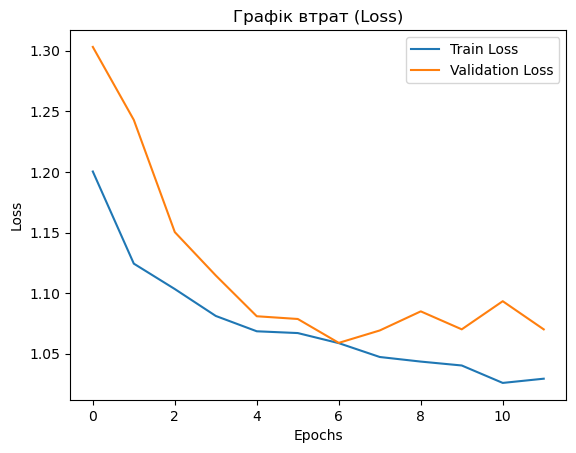

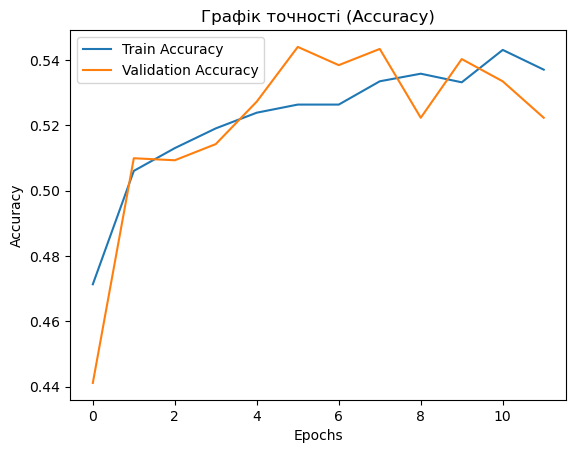

In [109]:
import matplotlib.pyplot as plt

# Графік втрат
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Графік втрат (Loss)')
plt.show()

# Графік точності
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Графік точності (Accuracy)')
plt.show()

In [68]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [70]:
# Прогнозування ймовірностей класів
predicted_probs = model.predict(X_test)  # Використовуємо навчену модель
predicted_classes = np.argmax(predicted_probs, axis=1)  # Перетворюємо ймовірності в класи
true_classes = np.argmax(y_test_encoded, axis=1)  # Істинні класи

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step


In [72]:
# Обчислення точності
accuracy = accuracy_score(true_classes, predicted_classes)
print(f"Model Accuracy: {accuracy:.2f}")

Model Accuracy: 0.54


In [74]:
# Звіт класифікації
classification_rep = classification_report(true_classes, predicted_classes)
print("Classification Report:")
print(classification_rep)

Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.45      0.45       394
           1       0.42      0.44      0.43       372
           2       0.57      0.53      0.55       394
           3       0.68      0.71      0.70       454

    accuracy                           0.54      1614
   macro avg       0.53      0.53      0.53      1614
weighted avg       0.54      0.54      0.54      1614



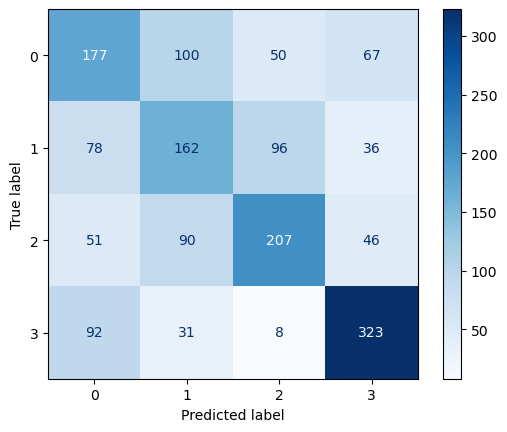

In [76]:
# Матриця плутанини
conf_matrix = confusion_matrix(true_classes, predicted_classes)
ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot(cmap="Blues")

1. Точність моделі становить 0.54, що є кращим, ніж в інших класичних класифікаційних моделях -> найвища була у SVM - 0.525. Суттєво зросла якість класифікації сегментів B і C (це показує як порівняння Confusion Matrix SVM і нейронної мережі, так і метрики precision, recall, F1-score).
2. Графіки втрат і точності показують відсутність явного перенавчання. Проте варто зазначити, що валідаційна точність і втрата досягають плато вже після кількох епох, що може вказувати на недостатню складність архітектури моделі та/або обмежену інформацію в даних для подальшого покращення узагальнення.
3. Для покращення моделі можемо використати стратегію збільшення складності архітектури вручну (додати більше прихованих шарів, збільшити кількість нейронів у шарах, змінити dropout і таким чином змінити регуляризацію, змінити функції активації, змінити learning rate) або використати оптимізатор Keras Tuner.

## **2. Convolutional Neural Networks (CNN)**

Завантаження датасету відбувається за допомогою Kaggle API (Intel Image Classifiction). Датасет містить розподіл зображень на тренувальні, тестові та для подальшого передбачення. Загалом наведені 6 класів зображень - вулиці, будівлі, моря, льодовики, гори, ліси (комплексні зображення природи).

In [221]:
import os

# Шлях до папки
dataset_path = "/Users/emmabrodina/Intellectual Data Analysis/Lab 3/intel-image-classification"

print("Вміст датасету:", os.listdir(dataset_path))

Вміст датасету: ['seg_test', 'seg_train', 'seg_pred']


In [211]:
# Шляхи до тренувальних і тестових папок
train_dir = os.path.join(dataset_path, "seg_train/seg_train")
test_dir = os.path.join(dataset_path, "seg_test/seg_test")

# Перевіряємо вміст папок
print("Train папка:", os.listdir(train_dir))
print("Test папка:", os.listdir(test_dir))

Train папка: ['forest', 'buildings', 'glacier', 'street', 'mountain', 'sea']
Test папка: ['forest', 'buildings', 'glacier', 'street', 'mountain', 'sea']


### 2.1. Data Preprocessing

In [58]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [60]:
# Аугментація даних для тренувального набору
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Вказуємо розділення на тренувальні та валідаційні дані
)

# Валідатор і тестовий генератор (без аугментації)
test_datagen = ImageDataGenerator(rescale=1.0/255)

In [95]:
# Завантаження тренувальних даних
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(240, 240),
    batch_size=32,
    class_mode='categorical',
    subset='training'  # Тільки тренувальні дані
)

# Завантаження валідаційних даних
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(240, 240),
    batch_size=32,
    class_mode='categorical',
    subset='validation'  # Тільки валідаційні дані
)

# Завантаження тестових даних
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(240, 240),
    batch_size=32,
    class_mode='categorical',
    shuffle=False 
)

# Перевірка кількості зображень
print(f"Кількість тренувальних зображень: {train_generator.samples}")
print(f"Кількість валідаційних зображень: {validation_generator.samples}")
print(f"Кількість тестових зображень: {test_generator.samples}")

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Кількість тренувальних зображень: 11230
Кількість валідаційних зображень: 2804
Кількість тестових зображень: 3000


In [64]:
# Перевіряємо класи зображень
print("Класи:", train_generator.class_indices)

Класи: {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


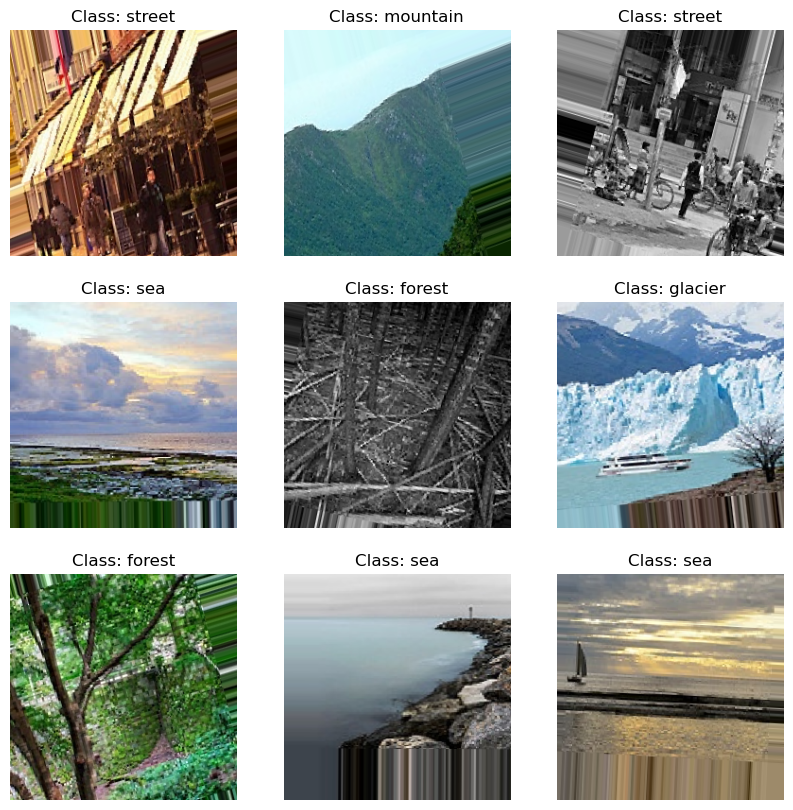

In [66]:
# Візуалізуємо кілька тренувальних зображень
import matplotlib.pyplot as plt

def show_images(generator, n_images=9):
    images, labels = next(generator)  # Отримуємо пакет зображень
    plt.figure(figsize=(10, 10))
    for i in range(n_images):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f"Class: {list(generator.class_indices.keys())[labels[i].argmax()]}")
        plt.axis("off")
    plt.show()

show_images(train_generator)

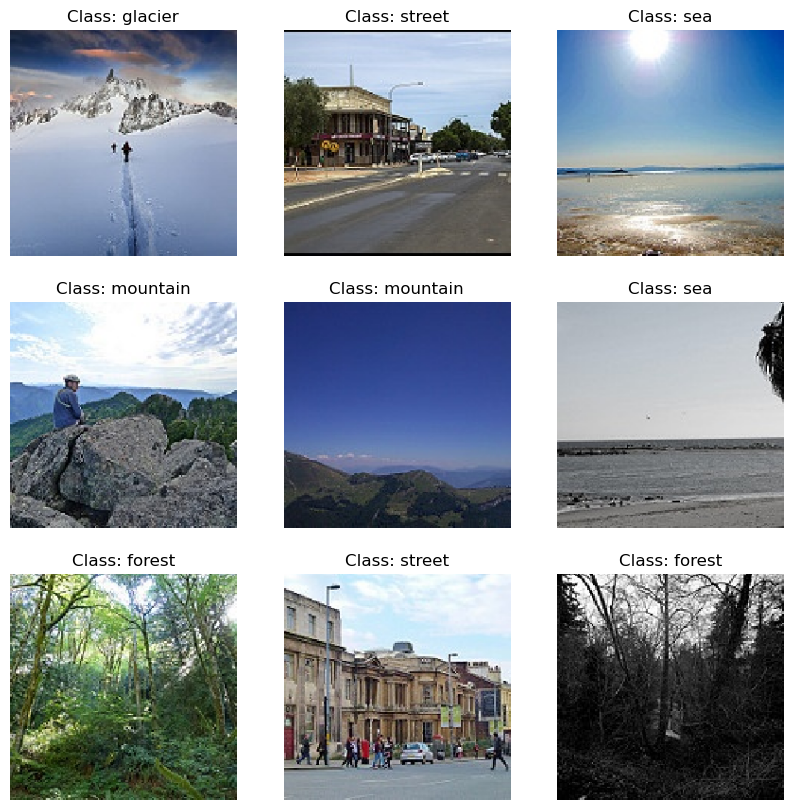

In [68]:
# Візуалізуємо кілька тестових зображень
show_images(test_generator)

### 2.2. Learning from Scratch

In [71]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [73]:
# Створення моделі "з нуля"
scratch_model = Sequential([
    Input(shape=(240, 240, 3)),  # Вхідний шар
    Conv2D(32, (3, 3), activation='relu', strides=1, padding='valid'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', strides=1, padding='valid'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', strides=1, padding='valid'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(6, activation='softmax')  # 6 класів для класифікації
])

# Компіляція моделі
scratch_model.compile(
    optimizer=Adam(learning_rate=0.001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

# Огляд моделі
scratch_model.summary()

# Рання зупинка
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,  # Зупинити навчання після 3 епох без покращення
    restore_best_weights=True
)

# Навчання моделі
scratch_history = scratch_model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 238, 238, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 119, 119, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 117, 117, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 58, 58, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,939,206 (49.36 MB)

 Trainable params: 12,939,206 (49.36 MB)

 Non-trainable params: 0 (0.00 B)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 205s 582ms/step - accuracy: 0.4153 - loss: 1.6025 - val_accuracy: 0.5795 - val_loss: 1.0942
Epoch 2/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 205s 583ms/step - accuracy: 0.5897 - loss: 1.0596 - val_accuracy: 0.6619 - val_loss: 0.9004
Epoch 3/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 206s 587ms/step - accuracy: 0.6225 - loss: 0.9762 - val_accuracy: 0.7051 - val_loss: 0.8062
Epoch 4/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 198s 563ms/step - accuracy: 0.6661 - loss: 0.9145 - val_accuracy: 0.7183 - val_loss: 0.7863
Epoch 5/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 201s 572ms/step - accuracy: 0.6715 - loss: 0.8587 - val_accuracy: 0.7364 - val_loss: 0.7215
Epoch 6/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 195s 556ms/step - accuracy: 0.7177 - loss: 0.7902 - val_accuracy: 0.7439 - val_loss: 0.6951
Epoch 7/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 196s 559ms/step - accuracy: 0.7215 - loss: 0.7701 - val_accuracy: 0.7643 - val_loss: 0.6608
Epoch 8/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 194s 551ms/step - accuracy: 0.7314 -

In [75]:
# Оцінка моделі
test_loss_scratch, test_acc_scratch = scratch_model.evaluate(test_generator)
print(f"Тестова точність (з нуля): {test_acc_scratch}")

/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


94/94 ━━━━━━━━━━━━━━━━━━━━ 13s 137ms/step - accuracy: 0.8279 - loss: 0.5064
Тестова точність (з нуля): 0.8226666450500488


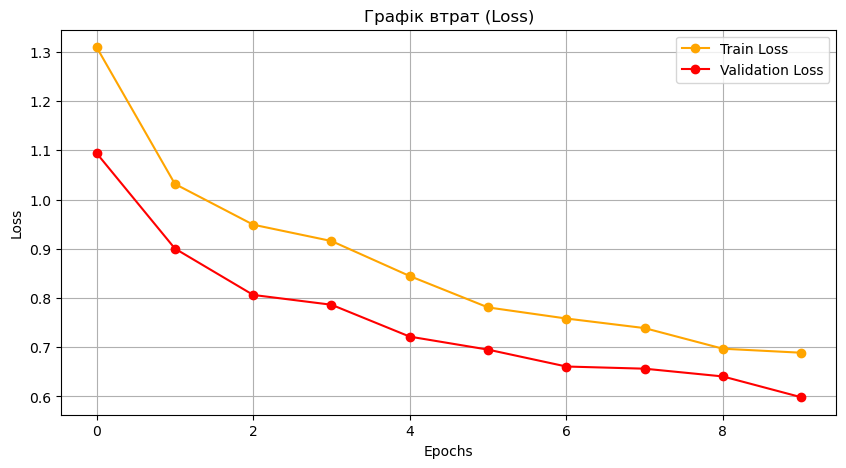

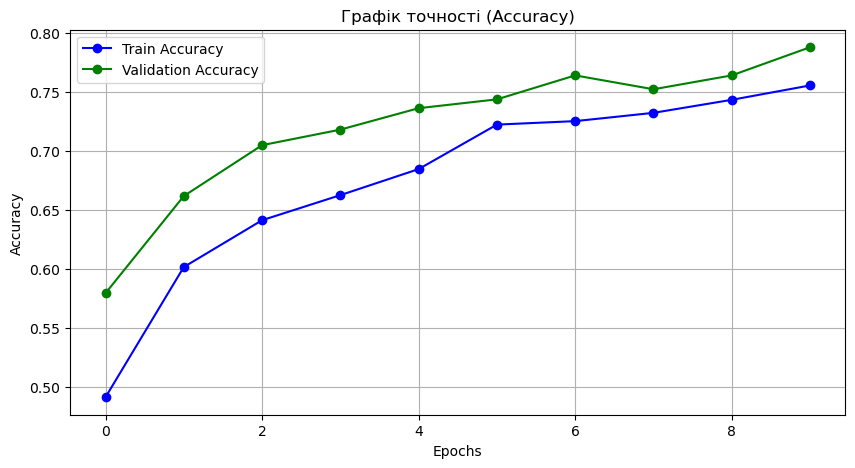

In [77]:
# Графік втрат
plt.figure(figsize=(10, 5))
plt.plot(scratch_history.history['loss'], label='Train Loss', color='orange', marker='o')
plt.plot(scratch_history.history['val_loss'], label='Validation Loss', color='red', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Графік втрат (Loss)')
plt.legend()
plt.grid(True)
plt.show()

# Графік точності
plt.figure(figsize=(10, 5))
plt.plot(scratch_history.history['accuracy'], label='Train Accuracy', color='blue', marker='o')
plt.plot(scratch_history.history['val_accuracy'], label='Validation Accuracy', color='green', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Графік точності (Accuracy)')
plt.legend()
plt.grid(True)
plt.show()

In [79]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [97]:
# Прогнозування ймовірностей класів
predicted_probs = scratch_model.predict(test_generator).argmax(axis=1)

# Істинні класи (з тестового генератора)
true_classes = test_generator.classes  # Використовуємо порядок генератора

# Перевірка точності
accuracy = accuracy_score(true_classes, predicted_probs)
print(f"Model Accuracy: {accuracy:.2f}")

/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


94/94 ━━━━━━━━━━━━━━━━━━━━ 13s 135ms/step
Model Accuracy: 0.82


In [107]:
# Звіт класифікації
classification_rep = classification_report(true_classes, predicted_probs)
print("Classification Report:")
print(classification_rep)

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.79      0.80       437
           1       0.96      0.96      0.96       474
           2       0.73      0.85      0.79       553
           3       0.80      0.75      0.77       525
           4       0.90      0.69      0.78       510
           5       0.79      0.90      0.84       501

    accuracy                           0.82      3000
   macro avg       0.83      0.82      0.82      3000
weighted avg       0.83      0.82      0.82      3000



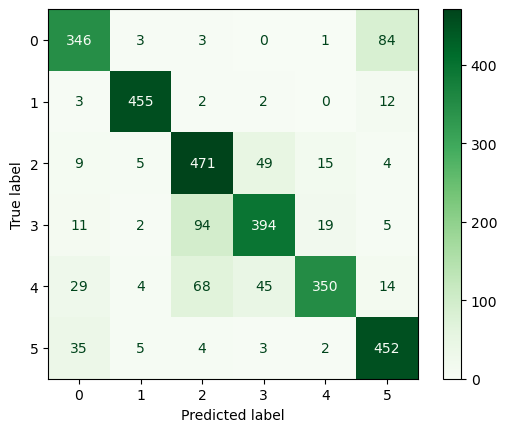

In [109]:
# Матриця плутанини
conf_matrix = confusion_matrix(true_classes, predicted_probs)
ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot(cmap="Greens")

In [115]:
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

In [223]:
# Шлях до папки з реальними даними
real_data_path = "/Users/emmabrodina/Intellectual Data Analysis/Lab 3/intel-image-classification/seg_pred/seg_pred"

def predict_and_display_images(model, real_data_path, class_labels, n=9):
    images = os.listdir(real_data_path)[:n]  # Вибираємо n зображень із папки
    plt.figure(figsize=(15, 15))

    for i, img_name in enumerate(images):
        img_path = os.path.join(real_data_path, img_name)
        
        # Завантажуємо зображення і перетворюємо його для моделі
        img = load_img(img_path, target_size=(240, 240))  
        img_array = img_to_array(img) / 255.0  # Масштабування
        img_array = np.expand_dims(img_array, axis=0)  # Додаємо batch розмір

        # Прогнозування класу
        predicted_prob = model.predict(img_array)
        predicted_class = np.argmax(predicted_prob)

        # Відображаємо зображення та його прогноз
        plt.subplot(3, 3, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Predicted: {class_labels[predicted_class]}")
    
    plt.tight_layout()
    plt.show()

In [161]:
class_labels = list(test_generator.class_indices.keys())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


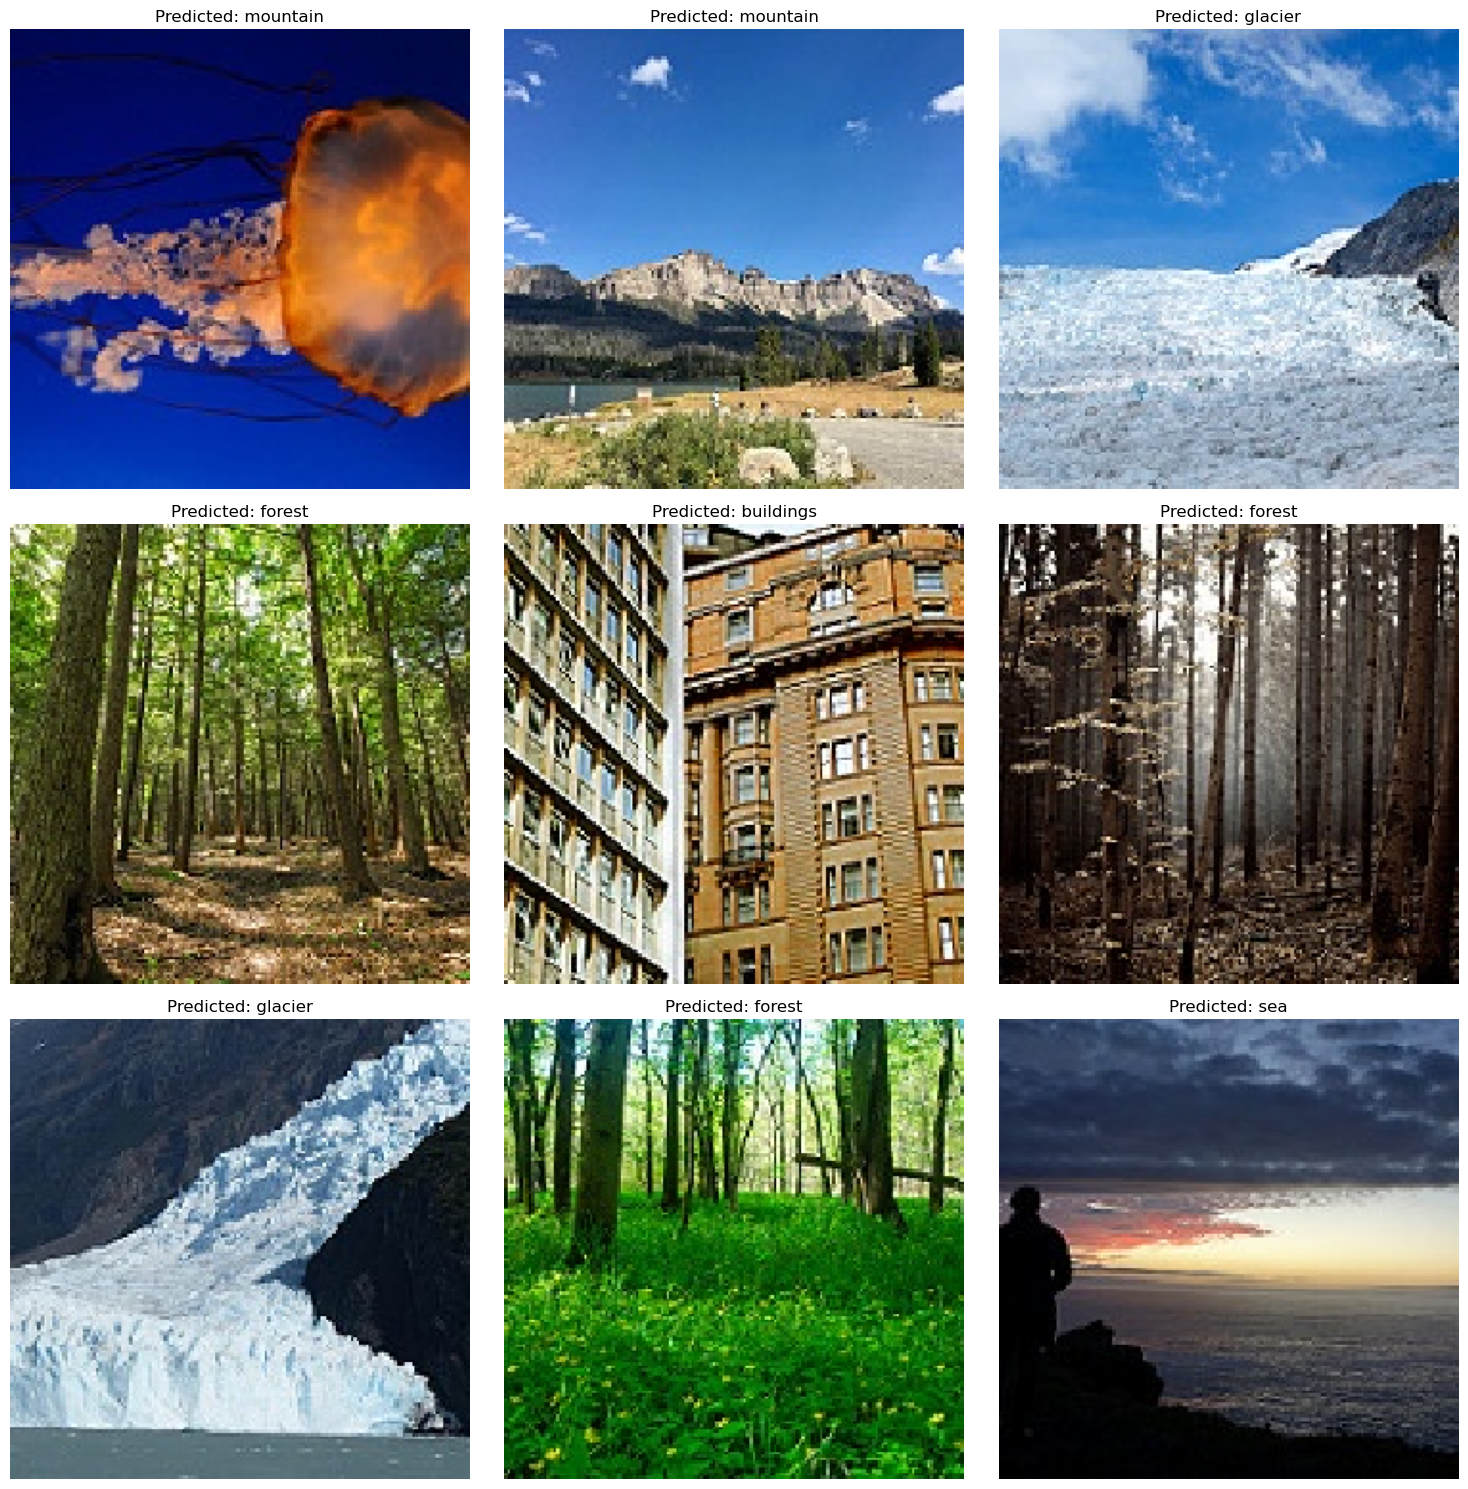

In [151]:
predict_and_display_images(scratch_model, real_data_path, class_labels, n=9)

In [219]:
# Збережемо модель
scratch_model.save("models/scratch_model.keras")

### 2.3. Transfer Learning from Pre-trained Weights

Використаємо модель EfficientNetB0, на відносно невеликій вибірці з 6 класів і розміром зображень (150х150) результати В0 практично не відрізнятимуться від результатів В7

In [173]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

In [175]:
# Завантаження InceptionV3
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(240, 240, 3))

# Розморозимо верхні 100 шарів
for layer in base_model.layers[:-100]:
    layer.trainable = False  # Заморожуємо нижні шари
for layer in base_model.layers[-100:]:
    layer.trainable = True   # Розморожуємо верхні шари

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 26s 0us/step


In [179]:
# Додаємо власні шари
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)  # Більше нейронів для більшої складності
x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(6, activation='softmax')(x)  # Вихідний шар для 6 класів

# Створюємо модель
transfer_model = Model(inputs=base_model.input, outputs=predictions)

# Компіляція моделі
transfer_model.compile(
    optimizer=Adam(learning_rate=0.00001),  # Низька швидкість навчання для запобігання "перезапису" передтренованих ваг
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Перевірка структури моделі
transfer_model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 240, 240,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 119, 119,  │        864 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 119, 119,  │         96 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 119, 119,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 117, 117,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 117, 117,  │         96 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 117, 117,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 117, 117,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 117, 117,  │        192 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 117, 117,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 58, 58,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 58, 58,    │      5,120 │ max_pooling2d_3[… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 58, 58,    │        240 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 58, 58,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 56, 56,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        576 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 56, 56,    │          0 │ batch_normalizat

 Total params: 22,360,998 (85.30 MB)

 Trainable params: 14,182,278 (54.10 MB)

 Non-trainable params: 8,178,720 (31.20 MB)

In [181]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

# Навчання моделі
transfer_history = transfer_model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 447s 1s/step - accuracy: 0.3978 - loss: 1.5127 - val_accuracy: 0.8673 - val_loss: 0.4703 - learning_rate: 1.0000e-05
Epoch 2/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 437s 1s/step - accuracy: 0.8125 - loss: 0.5784 - val_accuracy: 0.8912 - val_loss: 0.3046 - learning_rate: 1.0000e-05
Epoch 3/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 420s 1s/step - accuracy: 0.8613 - loss: 0.4241 - val_accuracy: 0.9037 - val_loss: 0.2705 - learning_rate: 1.0000e-05
Epoch 4/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 422s 1s/step - accuracy: 0.8736 - loss: 0.3880 - val_accuracy: 0.9080 - val_loss: 0.2555 - learning_rate: 1.0000e-05
Epoch 5/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 419s 1s/step - accuracy: 0.8916 - loss: 0.3251 - val_accuracy: 0.9187 - val_loss: 0.2467 - learning_rate: 1.0000e-05
Epoch 6/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 415s 1s/step - accuracy: 0.8999 - loss: 0.3006 - val_accuracy: 0.9151 - val_loss: 0.2389 - learning_rate: 1.0000e-05
Epoch 7/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 411s 1s/step - acc

In [183]:
# Оцінка моделі на тестових даних
test_loss_transfer, test_acc_transfer = transfer_model.evaluate(test_generator)
print(f"Тестова точність (Transfer Learning): {test_acc_transfer:.2f}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 59s 624ms/step - accuracy: 0.9256 - loss: 0.2224
Тестова точність (Transfer Learning): 0.93


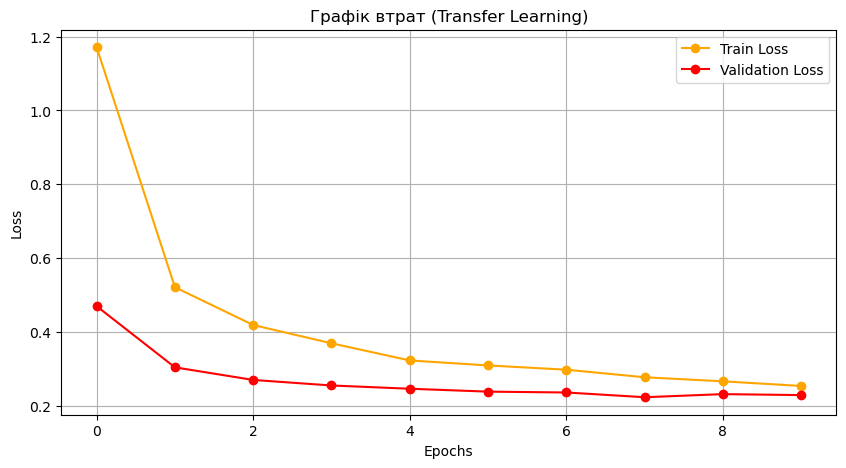

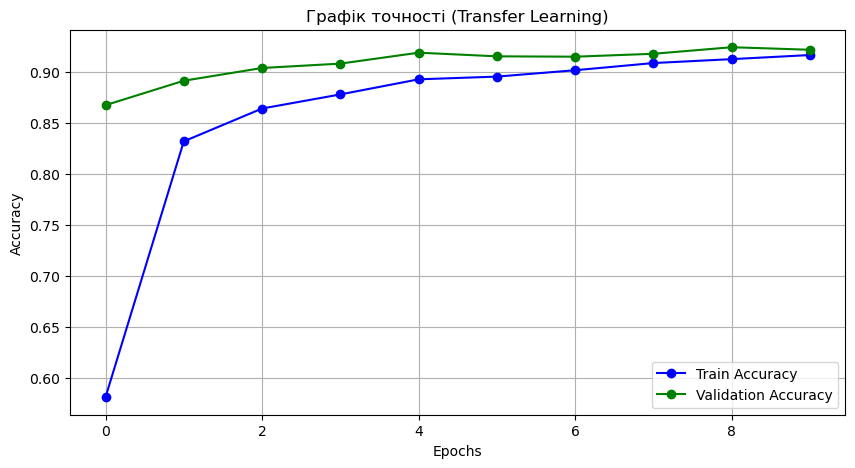

In [185]:
# Візуалізація точності
import matplotlib.pyplot as plt

# Візуалізація втрат
plt.figure(figsize=(10, 5))
plt.plot(transfer_history.history['loss'], label='Train Loss', color='orange', marker='o')
plt.plot(transfer_history.history['val_loss'], label='Validation Loss', color='red', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Графік втрат (Transfer Learning)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(transfer_history.history['accuracy'], label='Train Accuracy', color='blue', marker='o')
plt.plot(transfer_history.history['val_accuracy'], label='Validation Accuracy', color='green', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Графік точності (Transfer Learning)')
plt.legend()
plt.grid(True)
plt.show()

In [187]:
# Прогнозування ймовірностей класів
predicted_probs = transfer_model.predict(test_generator).argmax(axis=1)

# Істинні класи (з тестового генератора)
true_classes = test_generator.classes  

# Перевірка точності
accuracy = accuracy_score(true_classes, predicted_probs)
print(f"Model Accuracy: {accuracy:.2f}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 61s 643ms/step
Model Accuracy: 0.93


In [189]:
# Звіт класифікації
classification_rep = classification_report(true_classes, predicted_probs)
print("Classification Report:")
print(classification_rep)

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       437
           1       1.00      0.99      0.99       474
           2       0.89      0.86      0.88       553
           3       0.89      0.87      0.88       525
           4       0.94      0.99      0.96       510
           5       0.92      0.95      0.94       501

    accuracy                           0.93      3000
   macro avg       0.93      0.93      0.93      3000
weighted avg       0.93      0.93      0.93      3000



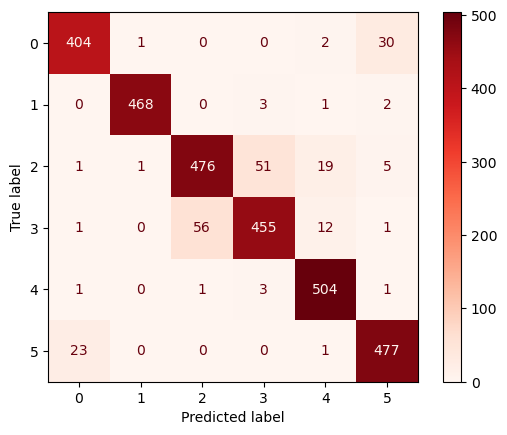

In [191]:
# Матриця плутанини
conf_matrix = confusion_matrix(true_classes, predicted_probs)
ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot(cmap="Reds")

In [199]:
def predict_and_display_images(model, real_data_path, class_labels, n=9):
    images = os.listdir(real_data_path)[:n]  # Вибираємо n зображень із папки
    plt.figure(figsize=(15, 15))

    for i, img_name in enumerate(images):
        img_path = os.path.join(real_data_path, img_name)
        
        # Завантажуємо зображення і перетворюємо його для моделі
        img = load_img(img_path, target_size=(240, 240))
        img_array = img_to_array(img) / 255.0  # Масштабування
        img_array = np.expand_dims(img_array, axis=0)  # Додаємо batch розмір

        # Прогнозування класу
        predicted_prob = model.predict(img_array)
        predicted_class = np.argmax(predicted_prob)

        # Відображаємо зображення та його прогноз
        plt.subplot(3, 3, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Predicted: {class_labels[predicted_class]}")
    
    plt.tight_layout()
    plt.show()

In [201]:
class_labels = list(test_generator.class_indices.keys())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


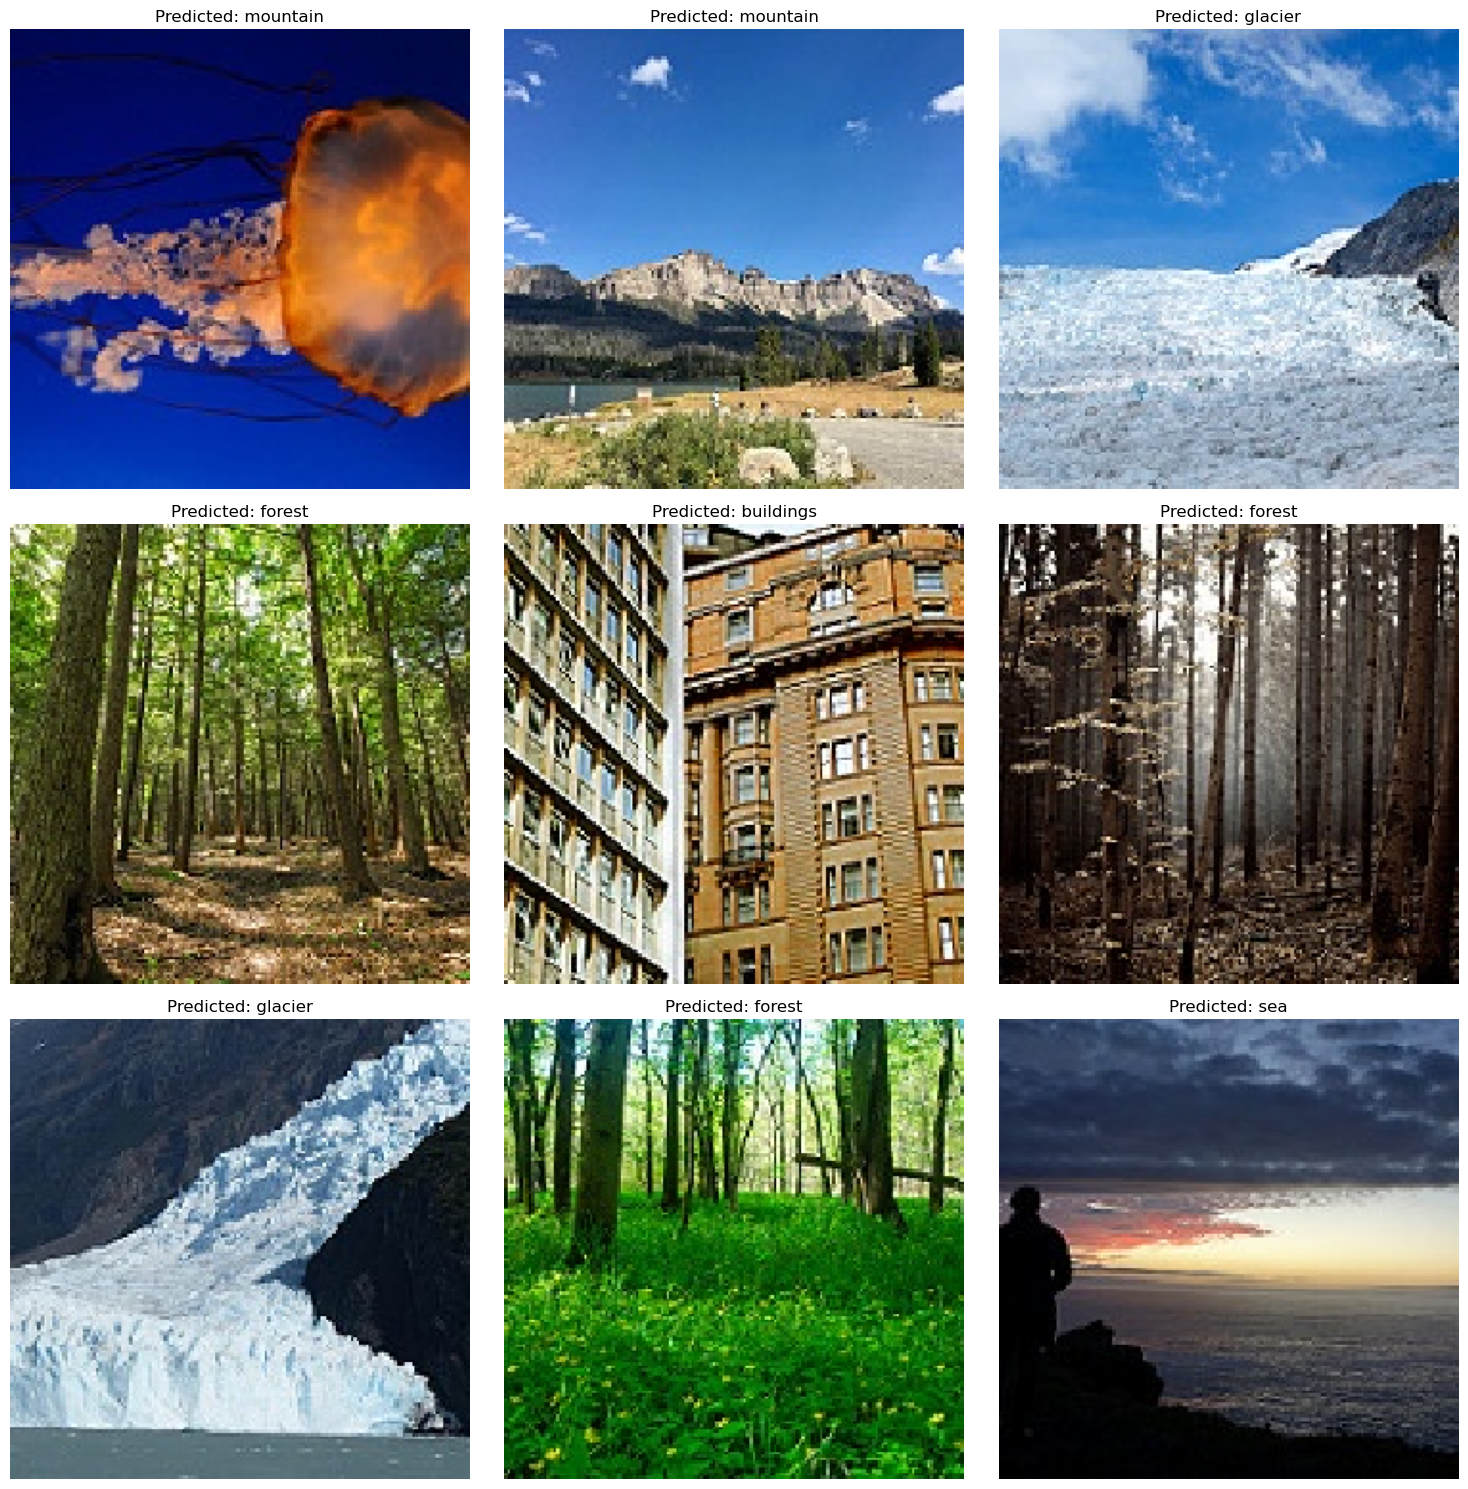

In [203]:
predict_and_display_images(transfer_model, real_data_path, class_labels, n=9)

In [217]:
# Збережемо модель
transfer_model.save("models/transfer_model.keras")

З огляду на отримані результати можна зробити висновок, що модель, яка використовує Transfer Learning краще справилась з цим завданням у порівнянні із навчанням моделі from scratch у зазначеній конфігурації (з врахуванням налаштованих параметрів у роботі).

## **3. Recurrent Neural Networks (RNN)**

In [1]:
import pandas as pd
import re
import string
import random
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [2]:
#Завантажимо дані
try:
    dt = pd.read_csv('finance_news.csv')
    print('Датасет завантажено успішно')
except FileNotFoundError:
    print('Файл не знайдено. Будь ласка, перевірте, чи правильно ви завантажили дані')
except Exception as e:
    print(f'Виникла проблема: {e}')

Датасет завантажено успішно


In [5]:
#Перевіримо, який % пропущених значень
def count_missings(dt):
    missing_values = dt.isnull().sum()
    missing_percentage = (missing_values / len(dt)) * 100
    missing_dt = pd.concat([missing_values, missing_percentage], axis=1)
    missing_dt.columns = ['Missing Count', 'Missing %']
    missing_dt_sorted = missing_dt[missing_dt['Missing %'] > 0.01].sort_values(by='Missing %', ascending=False)
    
    return missing_dt_sorted

count_missings(dt)

Missing Count  Missing %
text             14   0.042967

In [7]:
#Видалимо пропущені значення
dt_cleaned = dt.dropna(subset=['text'])
dt_cleaned.isnull().sum()

sentiment    0
text         0
dtype: int64

### 3.1. Data Preprocessing

In [10]:
# Видалення пропущених значень
dt_cleaned = dt.dropna(subset=['text']).reset_index(drop=True)

# Ініціалізація лематизатора і стоп-слів
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Функція очищення тексту
def clean_text(text):
    text = text.lower()
    text = re.sub(r'@\S+|https?://\S+|www\.\S+', '', text)  # Видалення URL
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)  # Видалення пунктуації
    text = re.sub(r'\s+', ' ', text).strip()  # Видалення зайвих пробілів
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
    return text

# Очищення текстів
dt_cleaned['text'] = dt_cleaned['text'].apply(clean_text)

In [12]:
# Агументація тексту (перестановка слів)
def augment_text(text):
    words = text.split()
    if len(words) > 1:
        idx1, idx2 = random.sample(range(len(words)), 2)
        words[idx1], words[idx2] = words[idx2], words[idx1]
    return ' '.join(words)

# Створення агументованого набору
dt_augmented = dt_cleaned.copy()
dt_augmented['text'] = dt_augmented['text'].apply(augment_text)

# Об'єднання оригінального і аргументованого наборів
dt_combined = pd.concat([dt_cleaned, dt_augmented]).reset_index(drop=True)

In [14]:
# Підготовка міток і токенізація
X = dt_combined['text']
y = dt_combined['sentiment']

In [16]:
# Токенізація тексту
max_words = 10000
max_len = 50
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X)
X_seq = pad_sequences(tokenizer.texts_to_sequences(X), maxlen=max_len)

In [18]:
# Кодування міток
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

In [104]:
# Розділення на навчальний і тестовий набори
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_categorical, test_size=0.2, random_state=42
)

In [106]:
print("Розмір навчального набору (X_train):", X_train.shape)
print("Розмір тестового набору (X_test):", X_test.shape)
print("Розмір навчальних міток (y_train):", y_train.shape)
print("Розмір тестових міток (y_test):", y_test.shape)

Розмір навчального набору (X_train): (52110, 50)
Розмір тестового набору (X_test): (13028, 50)
Розмір навчальних міток (y_train): (52110, 3)
Розмір тестових міток (y_test): (13028, 3)


### 3.2. Learning from Scratch

In [25]:
# Параметри
embedding_dim = 128
num_classes = 3
learning_rate = 0.001  # Оптимізований коефіцієнт навчання

# Побудова моделі
model = Sequential([
    Input(shape=(50,)),  # Явний вхідний шар
    Embedding(input_dim=10000, output_dim=embedding_dim),
    LSTM(128, return_sequences=True),  # Перший LSTM шар
    Dropout(0.2),
    LSTM(64),                          # Другий LSTM шар
    Dropout(0.2),                      # Збільшений Dropout для регуляризації
    Dense(num_classes, activation='softmax')  # Вихідний шар
])

# Оптимізатор із оптимізованим learning rate
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=learning_rate)

# Компіляція моделі
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Перевірка структури моделі
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 50, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 50, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,461,187 (5.57 MB)

 Trainable params: 1,461,187 (5.57 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
from tensorflow.keras.callbacks import EarlyStopping

# Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

# Навчання моделі
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=64,  # Оптимізований розмір партії
    epochs=20,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/20
815/815 ━━━━━━━━━━━━━━━━━━━━ 57s 68ms/step - accuracy: 0.5648 - loss: 0.8765 - val_accuracy: 0.7419 - val_loss: 0.6073
Epoch 2/20
815/815 ━━━━━━━━━━━━━━━━━━━━ 57s 71ms/step - accuracy: 0.7962 - loss: 0.5002 - val_accuracy: 0.7839 - val_loss: 0.5243
Epoch 3/20
815/815 ━━━━━━━━━━━━━━━━━━━━ 52s 64ms/step - accuracy: 0.8587 - loss: 0.3525 - val_accuracy: 0.8065 - val_loss: 0.4887
Epoch 4/20
815/815 ━━━━━━━━━━━━━━━━━━━━ 56s 69ms/step - accuracy: 0.9082 - loss: 0.2364 - val_accuracy: 0.8413 - val_loss: 0.4536
Epoch 5/20
815/815 ━━━━━━━━━━━━━━━━━━━━ 54s 67ms/step - accuracy: 0.9377 - loss: 0.1644 - val_accuracy: 0.8553 - val_loss: 0.4483
Epoch 6/20
815/815 ━━━━━━━━━━━━━━━━━━━━ 57s 70ms/step - accuracy: 0.9580 - loss: 0.1143 - val_accuracy: 0.8670 - val_loss: 0.5009
Epoch 7/20
815/815 ━━━━━━━━━━━━━━━━━━━━ 57s 70ms/step - accuracy: 0.9701 - loss: 0.0830 - val_accuracy: 0.8713 - val_loss: 0.5111
Epoch 8/20
815/815 ━━━━━━━━━━━━━━━━━━━━ 54s 66ms/step - accuracy: 0.9759 - loss: 0.0671 - 

In [29]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Точність на тестовому наборі: {test_accuracy:.2f}")

408/408 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8505 - loss: 0.4756
Точність на тестовому наборі: 0.86


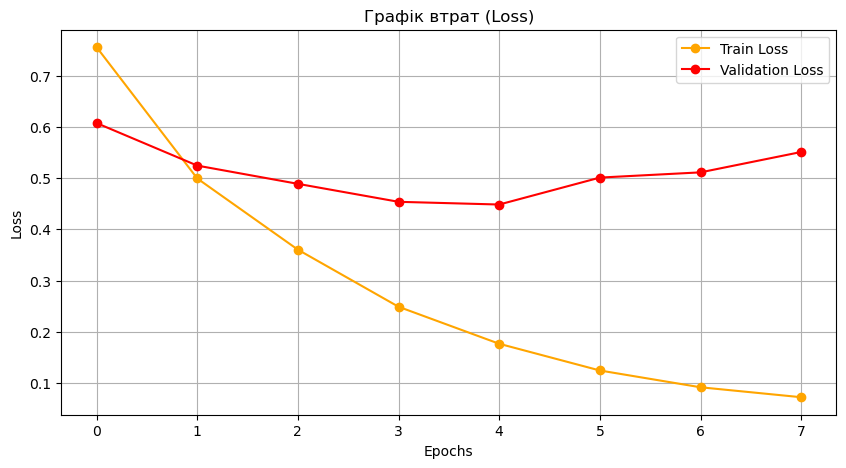

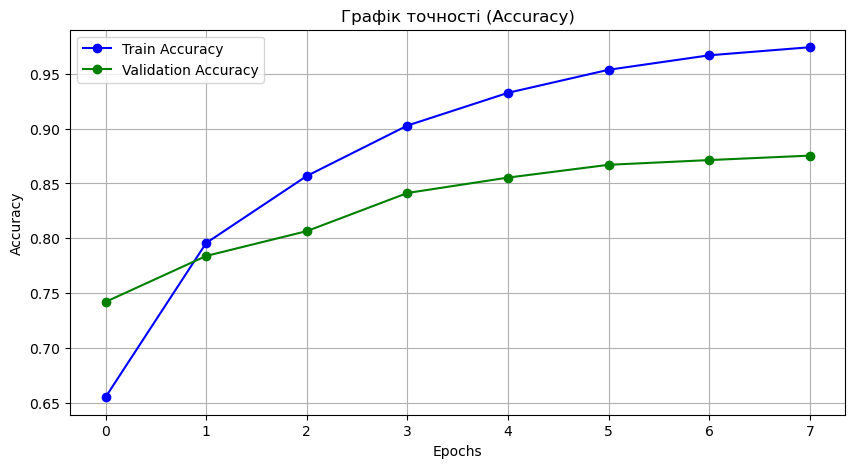

In [31]:
import matplotlib.pyplot as plt

# Візуалізація втрат
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss', color='orange', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Графік втрат (Loss)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='green', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Графік точності (Accuracy)')
plt.legend()
plt.grid(True)
plt.show()

Загалом спостерігається невеликий оверфітінг, але він не є критичним, оскільки:

1. Точність на навчальному наборі ~0.9, тоді як на валідаційному ~0.86. Це різниця всього 6%, що є прийнятною для багатьох реальних задач класифікації.
2. Навчальна втрата постійно знижується, а валідаційна стабілізується на прийнятному рівні. Якщо б валідаційна втрата почала різко зростати після певної кількості епох, це було б ознакою сильного оверфітингу, але тут ми цього не бачимо.
3. Модель суттєво покращилась після агументації даних (до агументації з різною регуляризацією коливалась у межах 0.54-0.62 точності, а після агументації - 0.84).

In [34]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [36]:
y_test = np.argmax(y_test, axis=1)
y_pred = np.argmax(model.predict(X_test), axis=1) 

# Перевірка точності
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

408/408 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step
Model Accuracy: 0.86


In [38]:
# Звіт класифікації
classification_rep = classification_report(y_test, y_pred)
print("Classification Report:")
print(classification_rep)

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.83      0.84      4380
           1       0.91      0.89      0.90      4362
           2       0.82      0.84      0.83      4286

    accuracy                           0.86     13028
   macro avg       0.86      0.86      0.86     13028
weighted avg       0.86      0.86      0.86     13028



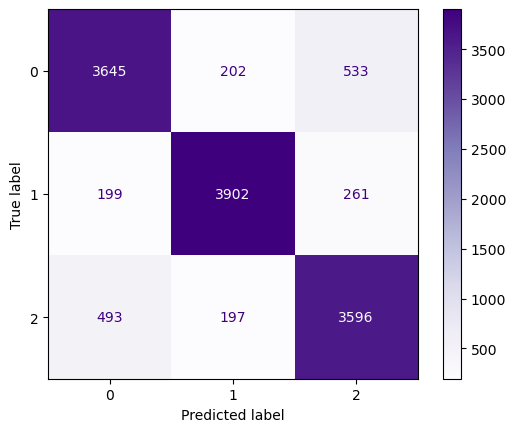

In [40]:
# Матриця плутанини
conf_matrix = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot(cmap="Purples")

### 3.3. Learning Using Pretrained Word Embeddings

Для ембедінгу будемо використовувати GloVe embeddings, натреновані у Стенфордському університеті (чудово підходять для навчання англомовних моделей)

In [44]:
embedding_path = "glove.6B.100d.txt"

# Завантаження ембедінгів GloVe у словник
embeddings_index = {}
with open(embedding_path, encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype="float32")
        embeddings_index[word] = coefs

print(f"Завантажено {len(embeddings_index)} слів із GloVe.")

Завантажено 400000 слів із GloVe.


In [46]:
word_index = tokenizer.word_index
num_tokens = len(word_index) + 2
embedding_dim = 100  #Використовуємо файл 6В.100d
hits = 0
misses = 0

# Створюємо ембедінгову матрицю
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Конвертовано %d слів (%d пропусків)" % (hits, misses))

Конвертовано 25810 слів (16320 пропусків)


In [48]:
missing_words = [word for word, i in word_index.items() if embeddings_index.get(word) is None]
print("Пропущені слова:", missing_words[:50]) 

Пропущені слова: ['marketscreener', 'marketscreener…', 'covid19', 'googul', 'brexit', 'amzn', 'nfx', 'stock…', 'world’s', 'googulxyz', 'sampp', 'china’s', 'qampa', 'it’s', 'eur0', 'znga', 'uschina', 'nvda', 'nkd', 'jdcom', 'trump’s', 'basware', 'ruukki', 'alpha…', 'ssys', 'travelnewsinsights', 'capman', 'shortterm', 'exdividend', 'don’t', 'draftkings', 'tsla', 'ooks', 'tmobile', 'fullyear', 'covid', '“the', 'here’s', 'yhoo', 'imho', 'yearonyear', 'hpq', 'more…', 'country’s', 'mreal', 'cybertruck', 'comdx', 'idata', 'eur1', 'poyry']


In [80]:
# Параметри
embedding_dim = 100  # Розмір GloVe-ембедінгів
num_classes = 3
learning_rate = 0.001

# Побудова моделі
embed_model = Sequential([
    Input(shape=(50,)),  # Явний вхідний шар
    Embedding(
        input_dim=num_tokens,          # Розмір словника
        output_dim=embedding_dim,      # Розмір ембедінгів
        weights=[embedding_matrix],    # Використовуємо GloVe-матрицю
        trainable=False                 
    ),
    LSTM(128, return_sequences=True),  # Перший LSTM шар
    Dropout(0.2),
    LSTM(64),                          # Другий LSTM шар
    Dropout(0.2),                      # Збільшений Dropout для регуляризації
    Dense(num_classes, activation='softmax')  # Вихідний шар
])

# Оптимізатор із оптимізованим learning rate
optimizer = Adam(learning_rate=learning_rate)

# Компіляція моделі
embed_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Перевірка структури моделі
embed_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 50, 100)        │     4,213,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 50, 128)        │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,380,051 (16.71 MB)

 Trainable params: 166,851 (651.76 KB)

 Non-trainable params: 4,213,200 (16.07 MB)

In [82]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Callback: ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

# Callback: Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

In [84]:
# Навчання моделі
embed_history = embed_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=64,
    epochs=20,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/20
815/815 ━━━━━━━━━━━━━━━━━━━━ 48s 58ms/step - accuracy: 0.5212 - loss: 0.9705 - val_accuracy: 0.6000 - val_loss: 0.8603 - learning_rate: 0.0010
Epoch 2/20
815/815 ━━━━━━━━━━━━━━━━━━━━ 43s 53ms/step - accuracy: 0.6178 - loss: 0.8241 - val_accuracy: 0.6528 - val_loss: 0.7596 - learning_rate: 0.0010
Epoch 3/20
815/815 ━━━━━━━━━━━━━━━━━━━━ 43s 53ms/step - accuracy: 0.6705 - loss: 0.7322 - val_accuracy: 0.6755 - val_loss: 0.7164 - learning_rate: 0.0010
Epoch 4/20
815/815 ━━━━━━━━━━━━━━━━━━━━ 44s 55ms/step - accuracy: 0.7114 - loss: 0.6453 - val_accuracy: 0.6967 - val_loss: 0.6891 - learning_rate: 0.0010
Epoch 5/20
815/815 ━━━━━━━━━━━━━━━━━━━━ 42s 51ms/step - accuracy: 0.7435 - loss: 0.5792 - val_accuracy: 0.7178 - val_loss: 0.6341 - learning_rate: 0.0010
Epoch 6/20
815/815 ━━━━━━━━━━━━━━━━━━━━ 42s 51ms/step - accuracy: 0.7751 - loss: 0.5182 - val_accuracy: 0.7335 - val_loss: 0.6196 - learning_rate: 0.0010
Epoch 7/20
815/815 ━━━━━━━━━━━━━━━━━━━━ 41s 50ms/step - accuracy: 0.8023 - l

In [86]:
test_loss, test_accuracy = embed_model.evaluate(X_test, y_test)
print(f"Точність на тестовому наборі: {test_accuracy:.2f}")

408/408 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7704 - loss: 0.5979
Точність на тестовому наборі: 0.78


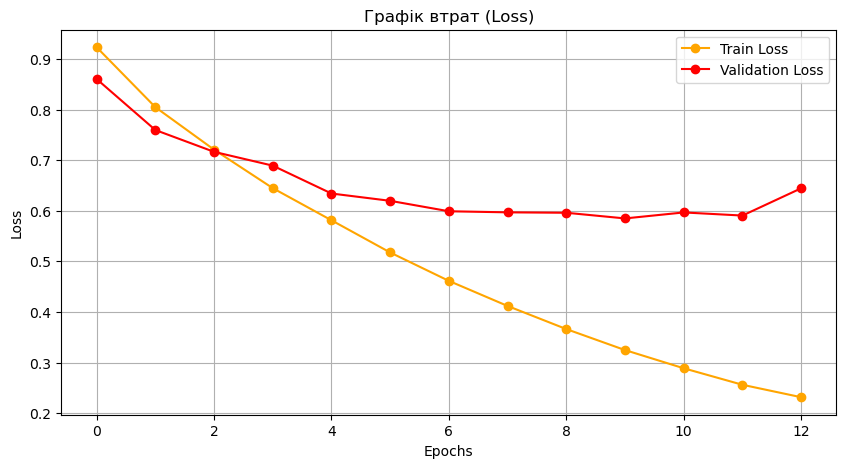

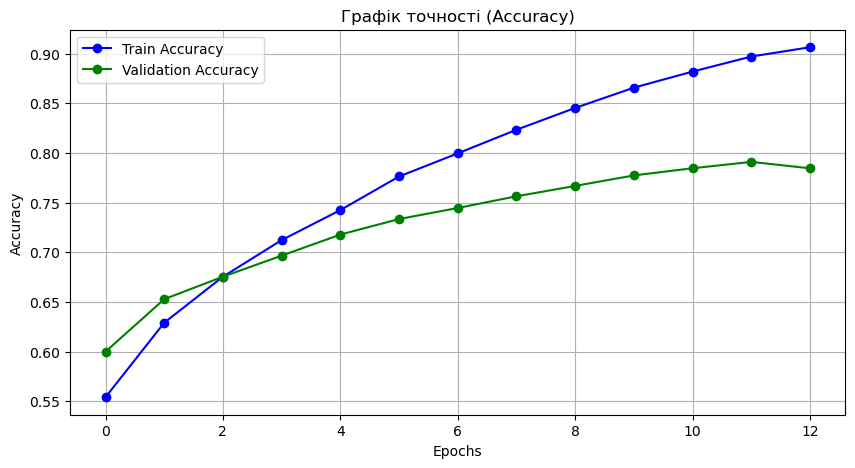

In [92]:
# Візуалізація втрат
plt.figure(figsize=(10, 5))
plt.plot(embed_history.history['loss'], label='Train Loss', color='orange', marker='o')
plt.plot(embed_history.history['val_loss'], label='Validation Loss', color='red', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Графік втрат (Loss)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(embed_history.history['accuracy'], label='Train Accuracy', color='blue', marker='o')
plt.plot(embed_history.history['val_accuracy'], label='Validation Accuracy', color='green', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Графік точності (Accuracy)')
plt.legend()
plt.grid(True)
plt.show()

In [110]:
y_pred = np.argmax(embed_model.predict(X_test), axis=1) 
y_test_true = np.argmax(y_test, axis=1)

# Перевірка точності
accuracy = accuracy_score(y_test_true, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

408/408 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step
Model Accuracy: 0.78


In [112]:
# Звіт класифікації
classification_rep = classification_report(y_test_true, y_pred)
print("Classification Report:")
print(classification_rep)

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.74      0.75      4380
           1       0.85      0.86      0.85      4362
           2       0.73      0.73      0.73      4286

    accuracy                           0.78     13028
   macro avg       0.78      0.78      0.78     13028
weighted avg       0.78      0.78      0.78     13028



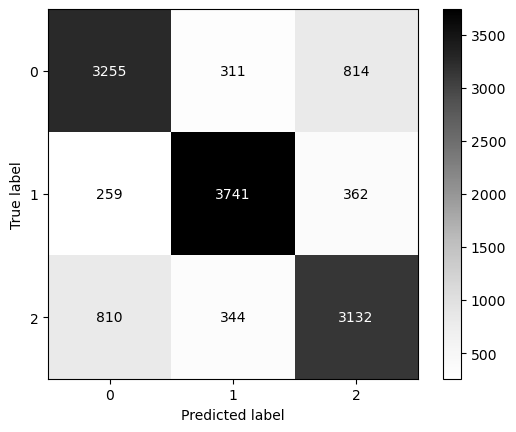

In [122]:
# Матриця плутанини
conf_matrix = confusion_matrix(y_test_true, y_pred)
ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot(cmap="Greys")

У класичних моделях найкращий результат показала модель SVM з лінійним ядром (0.672), а також моделі лінійної регресії (0.668) та наївного Баєса (0.632). Нейронні мережі значно краще справились з класифікацією тексту, адже навчена RNN модель "з нуля" показала точність 0.86, а модель з ембедінгом попередньо визначених weights - 0.78 (скоріш за все нижча точність пояснюється специфічною лексикою, яка використовується у фінансових новинах).